# Tile Drainage Code

In [118]:
#import libraries
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns

## 1. Importing WQP Data

In [67]:
def get_data(country=None, state=None, county=None, media=None, analytes=None, form="csv", providers=None, start_date=None, path=".", selected_cols=None):
    """
    Function get_data() imports data from the water quality portal given certain input parameters. 
    See https://www.waterqualitydata.us/#advanced=true for more info on paramters 
    """
    
    # Define the URL and parameters
    url = "https://www.waterqualitydata.us/data/Result/search"
    params = {}
    
    if country:
        params["countrycode"] = country
    if state:
        params["statecode"] = state
    if media:
        params["sampleMedia"] = media
    if analytes:
        params["characteristicName"] = analytes
    if form:
        params["mimeType"] = form
    if providers:
        params["providers"] = providers
    if start_date:
        params["startDateLo"] = start_date
    if county:
        params["countycode"] = county

    # Print the current working directory
    print("Current Working Directory:", os.getcwd())

    # Define the file path (customize if needed)
    file_path = os.path.join(path, "water_quality_data.csv")

    # Send the GET request
    response = requests.get(url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Write the content to a CSV file
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Data successfully downloaded and saved as '{file_path}'")

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Filter the DataFrame if selected_cols is provided
        if selected_cols:
            df = df[selected_cols]
        df = df.dropna(subset=['ResultMeasureValue'])
       
    else:
        print("Failed to download data. Status code:", response.status_code)
        
    return df

In [61]:
def get_locations(country, state, county, media, analytes, form, providers, path,selected_cols):
    
    
    # Define the WFS GetFeature URL and parameters
    url = "https://www.waterqualitydata.us/ogcservices/wfs/"
    
    # Define the base search parameters
    search_params = f"countrycode:{country};statecode:{state};sampleMedia:{'|'.join(media)};characteristicName:{'|'.join(analytes)};providers:{'|'.join(providers)}"
    
    # Optionally add the county code if it is provided
    if county:
        search_params += f";countycode:{county}"
    
    params = {
        "request": "GetFeature",
        "service": "wfs",
        "version": "2.0.0",
        "typeNames": "wqp_sites",
        "SEARCHPARAMS": search_params,
        "outputFormat": "application/json"
    }

    # Send the GET request
    response = requests.get(url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Write the content to a JSON file
        json_file_path = os.path.join(path, "water_quality_data.json")
        with open(json_file_path, "wb") as file:
            file.write(response.content)
        print(f"Data successfully downloaded and saved as '{json_file_path}'")

        # Load the JSON data into a DataFrame
        data = response.json()
        features = data.get('features', [])
        df = pd.json_normalize(features)
        
        # Split the coordinates into latitude and longitude if available
        if 'geometry.coordinates' in df.columns:
            df[['Longitude', 'Latitude']] = pd.DataFrame(df['geometry.coordinates'].tolist(), index=df.index)
            df.drop(columns=['geometry.coordinates'], inplace=True)
        
        # Save the DataFrame as a CSV file
        csv_file_path = os.path.join(path, "water_quality_data.csv")
        df.to_csv(csv_file_path, index=False)
        print(f"Data successfully extracted and saved as '{csv_file_path}'")
        df = df[selected_cols]

        return df
    else:
        print("Failed to download data. Status code:", response.status_code)
        return None


In [82]:
# Get data for given parameters
country = "US"
state = "US:36"
county = None  # County is optional
media = ["water", "Water"]
analytes = ["Nitrate", "Nitrate as N", "Nitrate-N","Nitrate-nitrogen","Nitrate-Nitrogen"]
form = "csv"
providers = ["NWIS", "STORET"]
start_date = '01-01-2000'
#Path to output file
path = "/Users/amitanand/Downloads/research_summer_2024/"
#Selected cols to simplify output
selected_cols = [
    "OrganizationIdentifier", "ActivityStartDate", "ActivityMediaSubdivisionName", 
    "MonitoringLocationIdentifier", "CharacteristicName", 
    "ResultMeasureValue", "ResultMeasure/MeasureUnitCode"
]

data_df = get_data(country, state, county, media, analytes, form, providers,start_date, path, selected_cols)
data_df = data_df.loc[data_df["ActivityMediaSubdivisionName"] == 'Surface Water']
data_df = data_df.loc[data_df["ResultMeasure/MeasureUnitCode"] != 'ug/l']

Current Working Directory: /Users/amitanand/Downloads
Data successfully downloaded and saved as '/Users/amitanand/Downloads/research_summer_2024/water_quality_data.csv'


/Users/amitanand/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (9,10,11,23,24,25,35,44,57,61) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [83]:
#Selected Cols to simplfy output
selected_cols = ['LongitudeMeasure', 'LatitudeMeasure','MonitoringLocationIdentifier']

#Reading in Downloaded Data for now
loc_df = pd.read_csv('/Users/amitanand/Downloads/research_summer_2024/WQP_locs.csv')
loc_df = loc_df[selected_cols]
loc_df= loc_df.rename(columns={'LongitudeMeasure':'Longitude','LatitudeMeasure':'Latitude'})

In [66]:

loc_df = get_locations(country, state, county, media, analytes, form, providers, path,selected_cols)

Failed to download data. Status code: 400


In [84]:
#loc_df = loc_df.rename(columns={'properties.name':"MonitoringLocationIdentifier"})
full_df = pd.merge(data_df, loc_df, on="MonitoringLocationIdentifier", how='left')

In [ ]:
full_df.to_csv(path+'quality_data.csv')

## 2. Importing CSI Data

In [85]:
#Import CSI Data
csi_data = pd.read_csv('/Users/amitanand/Downloads/research_summer_2024/Community Science Institute - Query Download - 06-17-2024 07_14_42.csv')
#Import CSI Sampling Locations
csi_locs = pd.read_csv('/Users/amitanand/Downloads/research_summer_2024/CSI-all_monitoring_regions_with_lat_long(AutoRecovered).csv')

#Format Data to Match that of the WQP
csi_data = csi_data[['Monitoring Location','Date','Analyte','Value','Unit',]]
csi_data = csi_data.rename(columns={'Monitoring Location':"MonitoringLocationIdentifier", 'Date':"ActivityStartDate", 'Analyte':"CharacteristicName", 'Value':"ResultMeasureValue", 'Unit':"ResultMeasure/MeasureUnitCode"})

csi_locs = csi_locs[['Monitoring.Location','Latitude','Longitude']].drop_duplicates()
csi_locs = csi_locs.rename(columns={'Monitoring.Location':"MonitoringLocationIdentifier"})

In [86]:
#Merge Locs and Data
csi_full_df = pd.merge(csi_data, csi_locs, on="MonitoringLocationIdentifier", how='left')

#Remove data that have no locatations
csi_full_df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

#Edit Format of CSI data to match WQP
csi_full_df['ResultMeasure/MeasureUnitCode'] = 'mg/l as N'
csi_full_df['ActivityMediaSubdivisionName'] = 'Surface Water'
csi_full_df['OrganizationIdentifier'] = 'CSI'
csi_full_df = csi_full_df[full_df.columns]

In [87]:
# Concatenate the two DataFrames
full_df = pd.concat([full_df, csi_full_df])

# Convert the 'ActivityStartDate' column to datetime format
full_df['ActivityStartDate'] = pd.to_datetime(full_df['ActivityStartDate'], errors='coerce')

# Drop rows with NaT in 'ActivityStartDate' (if any)
full_df = full_df.dropna(subset=['ActivityStartDate'])

# Filter the DataFrame for rows where 'ActivityStartDate' is on or after January 1, 2000
#full_df = full_df.loc[full_df['ActivityStartDate'] >= pd.Timestamp('2000-01-01')]

# Remove Data south of latitude 41 (greater NYC area)
full_df = full_df.loc[full_df['Latitude']>=41]

## 3. Modifying Units of Data

In [92]:
def process_samples(df):
    
'''Process samples() takes a df with repeating sampling locations and dates but unique values and units of 
either mg/l as N or NO3, it outputs a df with only one row per location/date and in units of mg/L as N'''

    def convert_to_n(group):
        
        '''convert_to_n takes a value or group of values sharing the same loc and date and converts it to a single value
        that is in units mg/l and N'''
        
        #if all of the values in the group are mg/L as NO3, take the average and convert to mg/l as N
        if all(group['ResultMeasure/MeasureUnitCode'] == 'mg/l asNO3'):
            return group['ResultMeasureValue'].astype(float).mean() * 0.226, 'mg/l as N'
        
        #if there are a combo of mg/L as N03 or mg/L as N or just mg/L as N, remove the mg/L as N03 and take the 
        #average of remaining mg/L as N unit valyes
        else:
            group = group[group['ResultMeasure/MeasureUnitCode'] != 'mg/l asNO3']
            return group['ResultMeasureValue'].astype(float).mean(), 'mg/l as N'

    # Group by location and date
    grouped = df.groupby(['MonitoringLocationIdentifier', 'ActivityStartDate'])

    # Apply the convert_to_n() to each group found above
    processed_data = grouped.apply(lambda x: pd.Series(convert_to_n(x), index=['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode'])).reset_index()

    # Merge with the original DataFrame to retain other columns
    new_df = pd.merge(processed_data, df.drop(columns=['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']), 
                         on=['MonitoringLocationIdentifier', 'ActivityStartDate'], how='left').drop_duplicates()

    return new_df

# Assuming 'full_df' is the DataFrame you are processing
units_adjusted_df = process_samples(full_df)

  MonitoringLocationIdentifier ActivityStartDate  ResultMeasureValue  \
0        21NYDECA_WQX-01010001        2008-04-22               0.223   
1        21NYDECA_WQX-01010001        2008-05-14               0.216   
2        21NYDECA_WQX-01010001        2008-06-24               0.434   
3        21NYDECA_WQX-01010001        2008-07-15               0.328   
4        21NYDECA_WQX-01010001        2008-09-03               0.162   

  ResultMeasure/MeasureUnitCode OrganizationIdentifier  \
0                     mg/l as N           21NYDECA_WQX   
1                     mg/l as N           21NYDECA_WQX   
2                     mg/l as N           21NYDECA_WQX   
3                     mg/l as N           21NYDECA_WQX   
4                     mg/l as N           21NYDECA_WQX   

  ActivityMediaSubdivisionName CharacteristicName  Longitude   Latitude  
0                Surface Water            Nitrate -79.063056  43.261111  
1                Surface Water            Nitrate -79.063056  43.26111

## 4. Preliminary Understanding of Nitrogen Data over time

In [95]:
# Convert sampling dates column to datetime format
units_adjusted_df['ActivityStartDate'] = pd.to_datetime(units_adjusted_df['ActivityStartDate'])

# Extract decade from sampling dates
units_adjusted_df['Decade'] = (units_adjusted_df['ActivityStartDate'].dt.year // 10) * 10

# Group DataFrame by decade
groups = units_adjusted_df.groupby('Decade')

# Create a dictionary to store DataFrames for each decade
decade_dfs = {}

# Iterate over groups and create a DataFrame for each decade
for decade, group_df in groups:
    decade_dfs[decade] = group_df



In [96]:
def loc_stats(df):
    
    '''loc_stats() groups a df with water quality data by its sampling locaation
    and find the first sample date, most recent sample date, average nitrate concentation, 
    the coordinates of that location, and the number of samples taken at this location'''
    
    location_stats = df.groupby('MonitoringLocationIdentifier').agg(
    MinSampleDate=('ActivityStartDate', 'min'),
    MaxSampleDate=('ActivityStartDate', 'max'),
    Latitude=('Latitude', 'first'),
    Longitude=('Longitude', 'first'),
    AverageSampleValue=('ResultMeasureValue', 'mean'),
    SampleCount=('ResultMeasureValue', 'count')
    ).reset_index()
    
    return location_stats

In [97]:
decade_dfs_group = {}


for decade, df in decade_dfs.items():

    #grouping values by location and taking mean of values, sum sample counts
    decade_dfs_group[decade] = loc_stats(df)

    #removing outliers in decade dfs for plotting purposes only
    max_count = math.ceil(decade_dfs_group[decade]['SampleCount'].quantile(0.97))
    max_val = math.ceil(decade_dfs_group[decade]['AverageSampleValue'].quantile(0.97))
    
    print(decade, max_count, max_val)
    decade_dfs_group[decade].loc[decade_dfs_group[decade]['SampleCount']>=max_count]=max_count
    decade_dfs_group[decade].loc[decade_dfs_group[decade]['AverageSampleValue']>=max_val]=max_val


2000 120 4
2010 84 4
2020 43 7


In [21]:
def plot_data(decade_dfs_group,param):

    '''plot_data() formats and plots spatial datasets on the basis of a given parameter'''
    
    n_plots = len(decade_dfs_group)
    fig, axs = plt.subplots(n_plots, 1, figsize=(10, n_plots * 5))

    # Iterate through the dictionary and plot
    for ax, (decade, df) in zip(axs, decade_dfs_group.items()):
    
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))
   
        gdf = gdf.set_crs(epsg=3857)
    

        # Plot monitoring locations, colored by average sample value
        ax = gdf.plot(ax = ax, 
                      markersize=50, 
                      column=param, 
                      cmap='viridis', legend=True, 
                      legend_kwds={'label': param, 
                                   'orientation': 'vertical', 'shrink': 0.5}, 
                      figsize=(1000,1000), 
                      vmin=0, 
                      vmax=max((df[param])))


        ax.set_title(f'Decade: {decade}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        ax.set_xlim(-80, -71)
        ax.set_ylim(40, 46)
        
        ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik, crs='epsg:3857',zoom=13)

    # Adjust layout
    plt.tight_layout()
    plt.show()

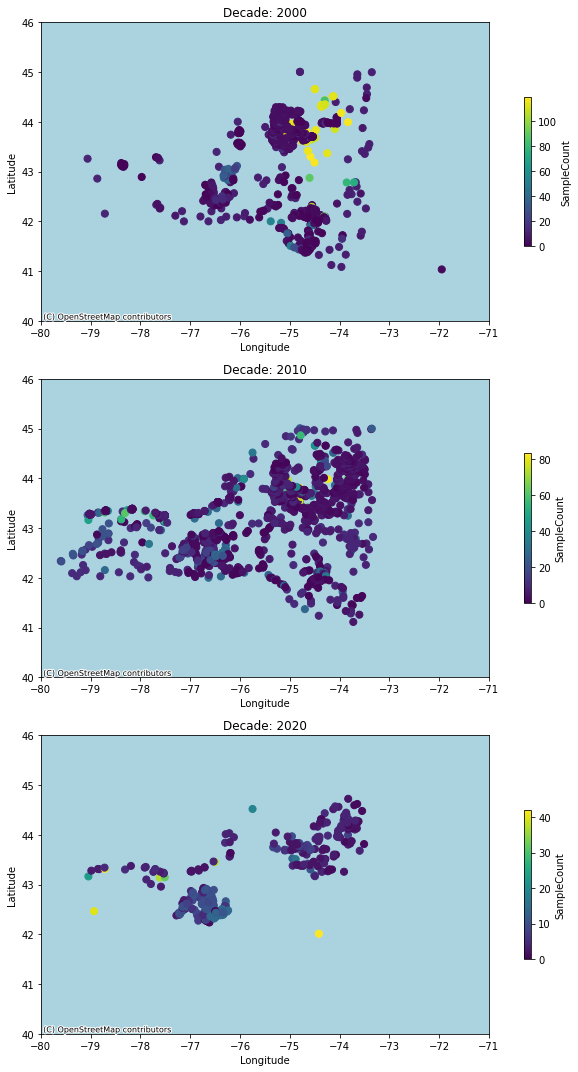

In [22]:
plot_data(decade_dfs_group,'SampleCount')

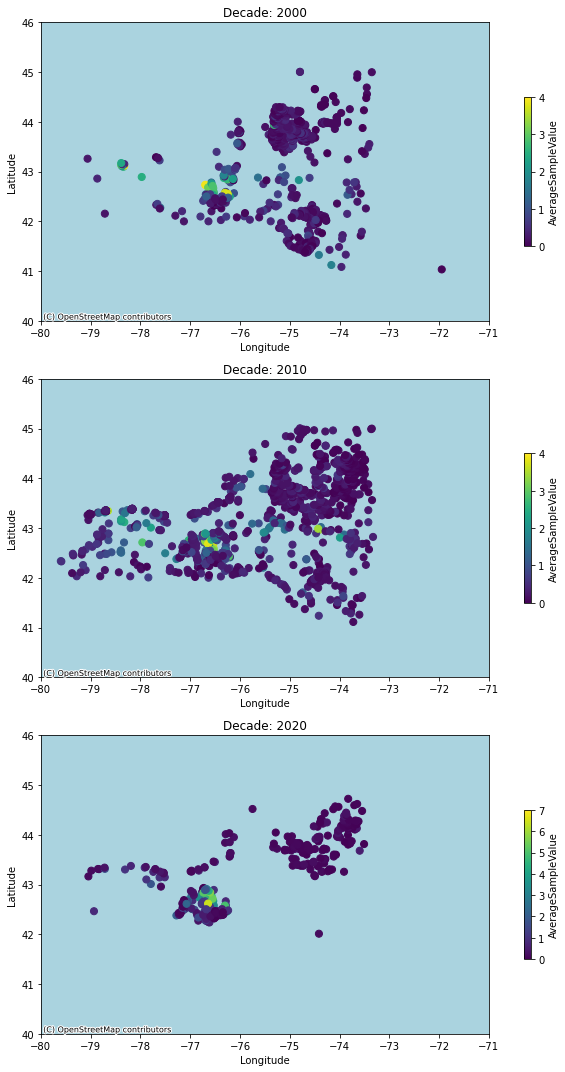

In [23]:
plot_data(decade_dfs_group,'AverageSampleValue')

## 5. Nitrogen Data with HUC12s

In [102]:
huc_data = gpd.read_file('/Users/amitanand/Downloads/research_summer_2024/spatial/HUC12_NY_shp/WBDHU12.shp')
huc_gdf = gpd.GeoDataFrame(huc_data)

In [25]:
all_points = loc_stats(units_adjusted_df)
points_gdf = gpd.GeoDataFrame(all_points, geometry=gpd.points_from_xy(all_points['Longitude'], all_points['Latitude']))
points_gdf = points_gdf.set_crs(huc_gdf.crs)

In [26]:
# Create an empty list to store results
points_in_huc = []

# Iterate over each polygon in huc_gdf
for index, polygon in huc_gdf.iterrows():
    # Check if each point in points_gdf is within the current polygon
    points_within_polygon = points_gdf[points_gdf.within(polygon['geometry'])]
    
    total_samples = np.nan
    # Calculate the average value of points within the polygon
    if not points_within_polygon.empty:
        average_value = points_within_polygon['AverageSampleValue'].mean()
        total_samples = points_within_polygon['SampleCount'].sum()
    else:
        average_value = None  # Handle cases where no points are within the polygon
    
    # Create a GeoDataFrame with a single row for the polygon and its average value
    polygon_data = {
        'geometry': polygon['geometry'],
        'name': polygon['name'],  # Replace 'name' with your actual identifier column name
        'average_value': average_value,
        'total_samples': total_samples
    }
    polygon_df = gpd.GeoDataFrame([polygon_data], crs=huc_gdf.crs)
    
    # Append the polygon_df to points_in_huc list
    points_in_huc.append(polygon_df)

# Concatenate all DataFrames in points_in_huc list into a single GeoDataFrame
points_in_huc = pd.concat(points_in_huc, ignore_index=True)

# Now points_in_huc contains polygons from huc_gdf with their respective average values


In [27]:
def plot_hucs(huc_gdf,parameter, name):
    # Define the custom colormap
    cmap = plt.get_cmap('Reds')  # Base colormap
    cmap.set_bad(color='grey')  # Color for NaN values

    # Convert parameter column to float and set NaNs for missing data
    huc_gdf[parameter] = huc_gdf[parameter].astype(float)
    huc_gdf[parameter] = huc_gdf[parameter].replace([np.inf, -np.inf], np.nan)

    # Plot with custom colormap
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    huc_gdf.plot(column=parameter, cmap=cmap, legend=True, ax=ax, missing_kwds={"color": "grey", "label": "No data"})

    # Add title and show plot
    plt.title(name+' by HUC12, 2000 - Present')
    plt.show()

<ipython-input-27-18cf357e1b20>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='grey')  # Color for NaN values


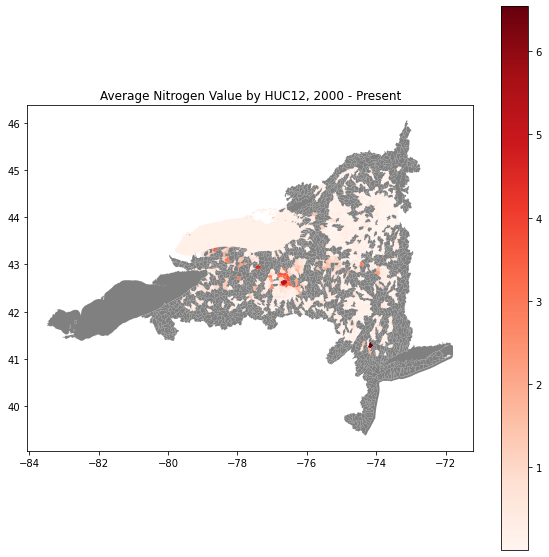

In [28]:
plot_hucs(points_in_huc,'average_value', 'Average Nitrogen Value')

<ipython-input-27-18cf357e1b20>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='grey')  # Color for NaN values


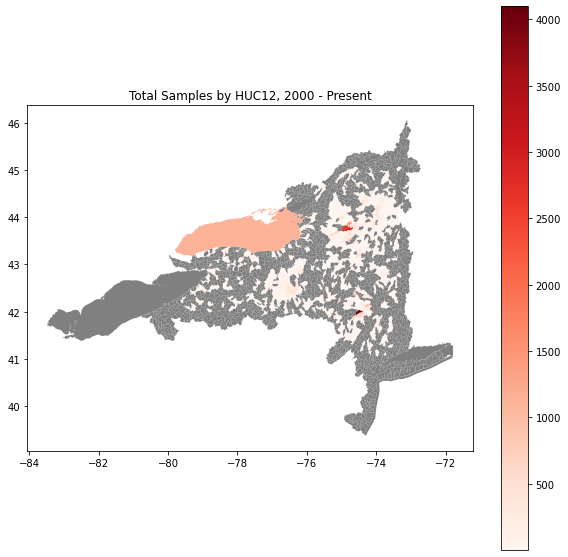

In [29]:
plot_hucs(points_in_huc,'total_samples', 'Total Samples')

## 6. Getting crop and tile drainage spatial data (done in QGIS)

## 7. Formatting Spatial Data in Python

In [125]:
crops = gpd.read_file('/Users/amitanand/Downloads/research_summer_2024/spatial/crops/nys_crops_100_points.shp')

In [128]:
tile = gpd.read_file('/Users/amitanand/Downloads/research_summer_2024/spatial/tile/tile_100_points.shp')

In [129]:
tile_gdf = gpd.GeoDataFrame(tile)


In [126]:
crops_gdf = gpd.GeoDataFrame(crops)

In [130]:
points_in_huc = points_in_huc.to_crs("EPSG:3857")

In [127]:
crops_gdf = crops_gdf.to_crs("EPSG:3857")

In [131]:
tile_gdf = tile_gdf.to_crs("EPSG:3857")

In [132]:
from shapely.validation import make_valid
# Function to clean geometries
def clean_geometry(geometry):
    if not geometry.is_valid:
        return make_valid(geometry)
    return geometry

# Clean geometries in both GeoDataFrames
points_in_huc['geometry'] = points_in_huc['geometry'].apply(clean_geometry)
crops_gdf['geometry'] = crops_gdf['geometry'].apply(clean_geometry)
tile_gdf['geometry'] = tile_gdf['geometry'].apply(clean_geometry)

In [133]:
def percent_in_poly(points_gdf, polygons_gdf, name):
    # Ensure both GeoDataFrames have the same CRS
    if polygons_gdf.crs != points_gdf.crs:
        points_gdf = points_gdf.to_crs(polygons_gdf.crs)

    # Perform a spatial join to find points within polygons

    points_within_polygons = gpd.sjoin(points_gdf, polygons_gdf, how="inner", predicate="within")
    print(points_within_polygons.columns)

    # Count total points in each polygon
    total_points_count = points_within_polygons['index_right'].value_counts()

    # Count points with value 1 in each polygon
    points_with_value_1 = points_within_polygons[points_within_polygons['VALUE'] == 1]
    points_with_value_1_count = points_with_value_1['index_right'].value_counts()

    # Create a DataFrame for the counts
    counts_df = pd.DataFrame({
        'total_points': total_points_count,
        'points_with_value_1': points_with_value_1_count
    })

    # Calculate the coverage percentage
    counts_df['coverage_percentage'+name] = (counts_df['points_with_value_1'] / counts_df['total_points']) * 100

    # Merge the coverage percentage back into the original polygons GeoDataFrame
    polygons_gdf = polygons_gdf.merge(counts_df['coverage_percentage'+name], left_index=True, right_index=True, how='left').fillna(0)

    return polygons_gdf

In [275]:
# Running the above function 
points_in_huc_crop = percent_in_poly(crops_gdf,points_in_huc,'crop')
points_in_huc_final = percent_in_poly(tile_gdf, points_in_huc_crop,'tile')

Index(['VALUE', 'geometry', 'index_right', 'name', 'average_value',
       'total_samples'],
      dtype='object')
Index(['VALUE', 'geometry', 'index_right', 'name', 'average_value',
       'total_samples', 'coverage_percentagecrop'],
      dtype='object')


In [276]:
# getting proportion of tile drainage column (restricted to HUC12s that have greater than 5% crop cover)
tile_edit = points_in_huc_final['coverage_percentagetile'].loc[points_in_huc_final['coverage_percentagetile']>5]
crop_edit = points_in_huc_final['coverage_percentagecrop'].loc[points_in_huc_final['coverage_percentagecrop']>5]
points_in_huc_final['tile_proportion'] = tile_edit/crop_edit

<ipython-input-27-18cf357e1b20>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='grey')  # Color for NaN values


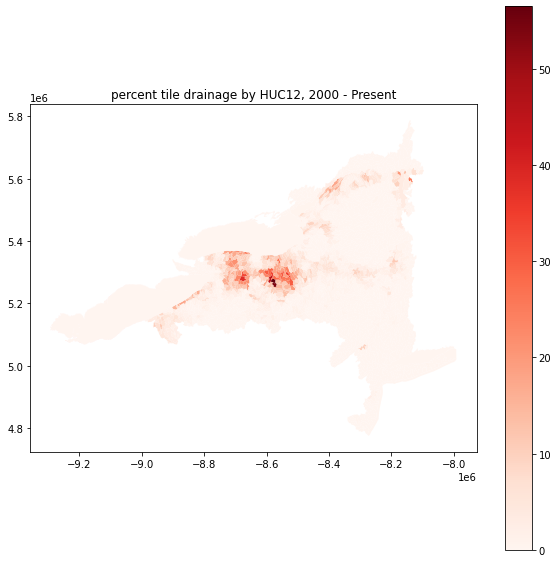

In [277]:
plot_hucs(points_in_huc_final,'coverage_percentagetile','percent tile drainage')

<ipython-input-27-18cf357e1b20>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='grey')  # Color for NaN values


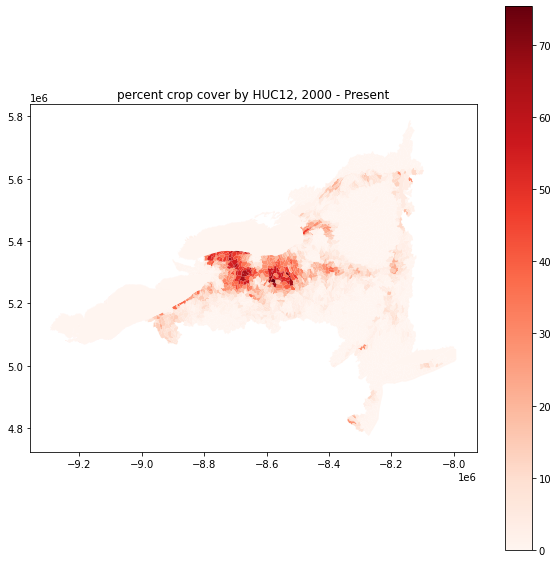

In [278]:
plot_hucs(points_in_huc_final,'coverage_percentagecrop','percent crop cover')

<ipython-input-27-18cf357e1b20>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='grey')  # Color for NaN values


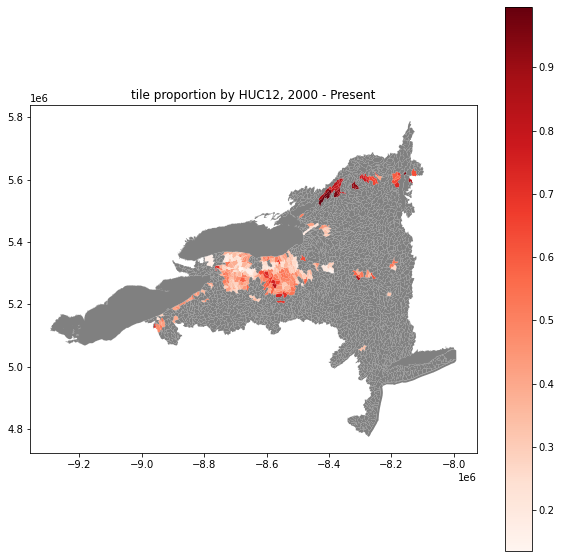

In [279]:
plot_hucs(points_in_huc_final,'tile_proportion','tile proportion')

## 8. Statistical Analysis

In [284]:
points_in_huc_final_plot = points_in_huc_final
points_in_huc_final_plot.loc[points_in_huc_final_plot['coverage_percentagecrop']== 0] = np.nan
points_in_huc_final_plot.loc[points_in_huc_final_plot['average_value']== 0] = np.nan
points_in_huc_final_plot.loc[points_in_huc_final_plot['coverage_percentagetile']== 0] = np.nan

y_prop = points_in_huc_final_plot['average_value'].loc[points_in_huc_final_plot['tile_proportion']>0].dropna()
x_crop = points_in_huc_final_plot[['coverage_percentagecrop']].dropna()
x_tile = points_in_huc_final_plot[['coverage_percentagetile']].dropna()
x_prop = points_in_huc_final_plot[['tile_proportion']].dropna()
y = points_in_huc_final_plot[['average_value']].dropna()



In [290]:
def regression(x, y, x_name, y_name):
    '''regression() has inputs of independent (x) and dependent (y) variables
    and returns a plot with a linear model overlayed. The regression statistics
    are also returned'''
    
    
    # Add a constant to the independent variable
    x = sm.add_constant(x)
    
    # Fit the OLS model
    model = sm.OLS(y, x).fit()
    
    # Print the regression summary
    print(model.summary())

    # Extract the intercept and coefficient
    intercept, coef = model.params

    # Make predictions
    y_pred = model.predict(x)

    # Calculate R-squared
    r_squared = model.rsquared

    # Plot the data points
    plt.scatter(x.iloc[:, 1], y, label='Data points')

    # Plot the regression line
    plt.plot(x.iloc[:, 1], y_pred, color='red', label='Regression line')

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.legend()
    plt.show()

                            OLS Regression Results                            
Dep. Variable:          average_value   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     245.0
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           4.43e-42
Time:                        12:57:36   Log-Likelihood:                -303.60
No. Observations:                 346   AIC:                             611.2
Df Residuals:                     344   BIC:                             618.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

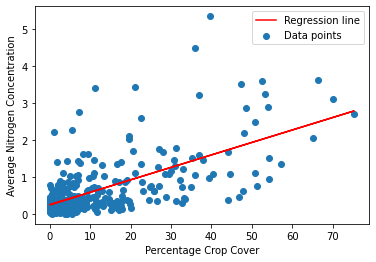

In [291]:
regression(x_crop,y,'Percentage Crop Cover','Average Nitrogen Concentration')

                            OLS Regression Results                            
Dep. Variable:          average_value   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     154.1
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           1.70e-29
Time:                        12:57:43   Log-Likelihood:                -332.59
No. Observations:                 346   AIC:                             669.2
Df Residuals:                     344   BIC:                             676.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

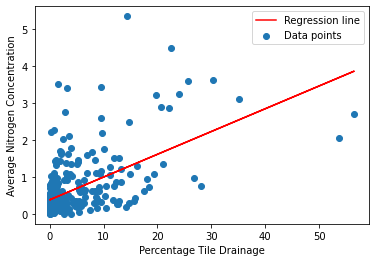

In [292]:
regression(x_tile,y,'Percentage Tile Drainage','Average Nitrogen Concentration')

                            OLS Regression Results                            
Dep. Variable:          average_value   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6961
Date:                Mon, 15 Jul 2024   Prob (F-statistic):              0.407
Time:                        12:57:46   Log-Likelihood:                -123.24
No. Observations:                  82   AIC:                             250.5
Df Residuals:                      80   BIC:                             255.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4376      0.327     

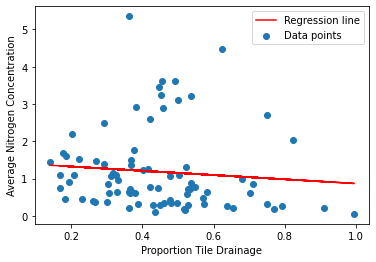

In [293]:
regression(x_prop,y_prop,'Proportion Tile Drainage','Average Nitrogen Concentration')

                            OLS Regression Results                            
Dep. Variable:          average_value   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     245.0
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           4.43e-42
Time:                        22:36:09   Log-Likelihood:                -303.60
No. Observations:                 346   AIC:                             611.2
Df Residuals:                     344   BIC:                             618.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

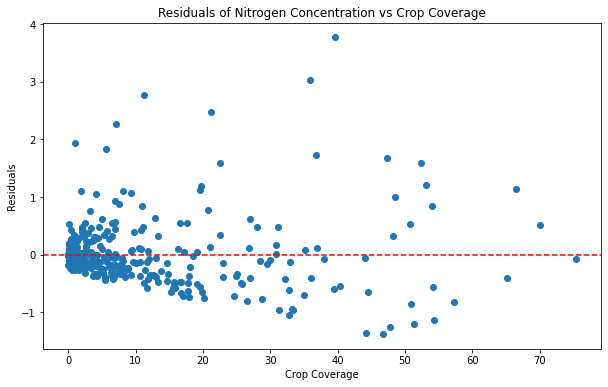

In [142]:

# Independent variable (Crop Coverage)
X_crop = sm.add_constant(x_crop)

# Fit the model
model = sm.OLS(y, X_crop).fit()

# Print the summary
print(model.summary())

# Get the residuals
residuals = model.resid

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(x_crop, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Crop Coverage')
plt.ylabel('Residuals')
plt.title('Residuals of Nitrogen Concentration vs Crop Coverage')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.001230
Date:                Thu, 11 Jul 2024   Prob (F-statistic):              0.972
Time:                        22:36:17   Log-Likelihood:                -303.60
No. Observations:                 346   AIC:                             611.2
Df Residuals:                     344   BIC:                             618.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

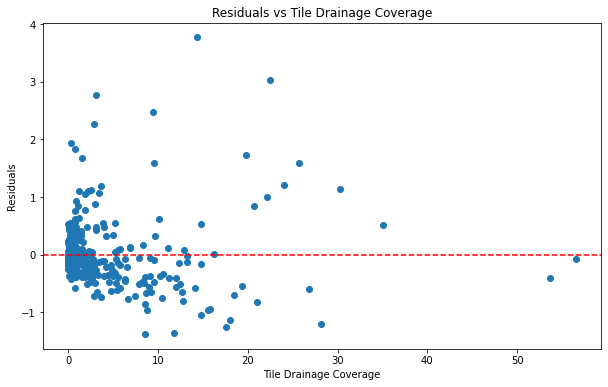

In [143]:
# Independent variable (Tile Drainage Coverage)
X_tile = sm.add_constant(x_tile)

# Dependent variable (Residuals from the previous model)
y_residuals = residuals

# Fit the model
model_tile = sm.OLS(y_residuals, X_tile).fit()

# Print the summary
print(model_tile.summary())

# Plot the relationship between Tile Drainage Coverage and Residuals
plt.figure(figsize=(10, 6))
plt.scatter(x_tile, y_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Tile Drainage Coverage')
plt.ylabel('Residuals')
plt.title('Residuals vs Tile Drainage Coverage')
plt.show()

In [144]:
# Define the independent variables (Crop Coverage and Tile Drainage Coverage)
X = points_in_huc_final_plot[['coverage_percentagecrop','coverage_percentagetile']].dropna()

X = sm.add_constant(X)  # Add a constant term for the intercept

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          average_value   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     122.2
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           8.71e-41
Time:                        22:36:21   Log-Likelihood:                -303.59
No. Observations:                 346   AIC:                             613.2
Df Residuals:                     343   BIC:                             624.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

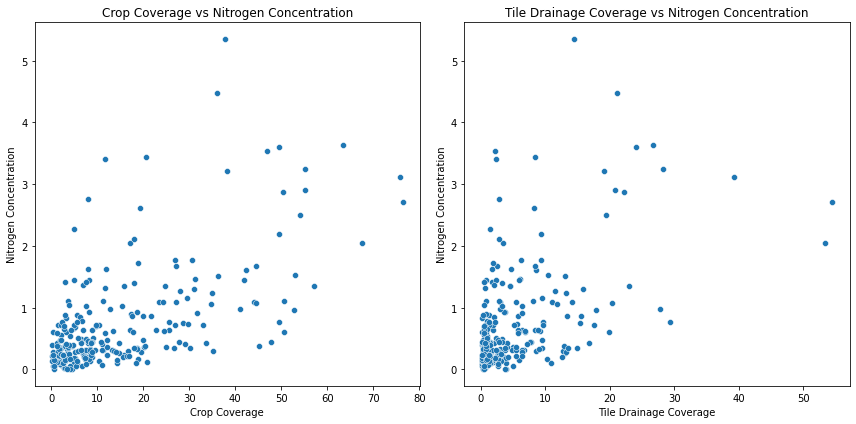

In [124]:
# Plotting the data
plt.figure(figsize=(12, 6))

# Scatter plot of Crop Coverage vs Nitrogen Concentration
plt.subplot(1, 2, 1)
sns.scatterplot(x='coverage_percentagecrop', y='average_value', data=points_in_huc_final_plot)
plt.plot(x_crop, model.predict(X) - x_tile * model.params['coverage_percentagetile'], color='red')
plt.title('Crop Coverage vs Nitrogen Concentration')
plt.xlabel('Crop Coverage')
plt.ylabel('Nitrogen Concentration')

# Scatter plot of Tile Drainage Coverage vs Nitrogen Concentration
plt.subplot(1, 2, 2)
sns.scatterplot(x='coverage_percentagetile', y='average_value', data=points_in_huc_final_plot)
plt.plot(x_tile, model.predict(X) - x_crop * model.params['coverage_percentagecrop'], color='red')
plt.title('Tile Drainage Coverage vs Nitrogen Concentration')
plt.xlabel('Tile Drainage Coverage')
plt.ylabel('Nitrogen Concentration')

plt.tight_layout()
plt.show()

In [145]:
points_in_huc_final_plot['tile_proportion'] = points_in_huc_final_plot['coverage_percentagetile']/points_in_huc_final_plot['coverage_percentagecrop']

In [152]:
points_in_huc_final_plot['coverage_percentagetile']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2116   NaN
2117   NaN
2118   NaN
2119   NaN
2120   NaN
Name: coverage_percentagetile, Length: 2121, dtype: float64

In [153]:
points_in_huc_final_plot

,geometry,name,average_value,total_samples,coverage_percentagecrop,coverage_percentagetile,tile_proportion
0,None,NaN,NaN,NaN,NaN,NaN,NaN
1,None,NaN,NaN,NaN,NaN,NaN,NaN
2,None,NaN,NaN,NaN,NaN,NaN,NaN
3,None,NaN,NaN,NaN,NaN,NaN,NaN
4,None,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2116,None,NaN,NaN,NaN,NaN,NaN,NaN
2117,None,NaN,NaN,NaN,NaN,NaN,NaN
2118,None,NaN,NaN,NaN,NaN,NaN,NaN
2119,None,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
plt.scatter()

In [202]:
points_in_huc_final_plot

,geometry,name,average_value,total_samples,coverage_percentagecrop,coverage_percentagetile,tile_proportion
0,None,NaN,NaN,NaN,NaN,NaN,NaN
1,None,NaN,NaN,NaN,NaN,NaN,NaN
2,None,NaN,NaN,NaN,NaN,NaN,NaN
3,None,NaN,NaN,NaN,NaN,NaN,NaN
4,None,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2116,None,NaN,NaN,NaN,NaN,NaN,NaN
2117,None,NaN,NaN,NaN,NaN,NaN,NaN
2118,None,NaN,NaN,NaN,NaN,NaN,NaN
2119,None,NaN,NaN,NaN,NaN,NaN,NaN
